In [2]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

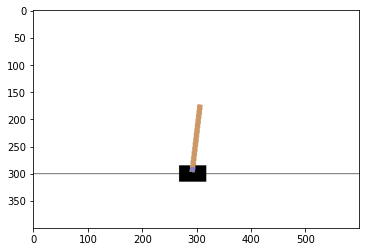

In [ ]:
#PPO-A2C for CartPole


import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten
from keras.optimizers import Adam
from keras.layers.convolutional import Convolution2D
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from keras import backend as k
display = Display(visible=0, size=(400, 300))
display.start()

class PPOAgent:
  def __init__(self,state_size,action_size):
    self.state_size=state_size
    self.action_size=action_size
    self.gamma=0.99
    self.learning_rate=0.001
    self.states=[]
    self.rewards=[]
    self.labels=[]
    self.prob=[]
    self.Actor=self.build_actor_model()
    self.Critic=self.build_critic_model()
  
    self.Critic.summary()
  
  def build_actor_model(self):
    logdir= "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback=keras.callbacks.TensorBoard(log_dir=logdir)

    Actor=Sequential()
    Actor.add(Dense(64,input_dim=self.state_size,activation='relu',kernel_initializer='glorot_uniform'))
    Actor.add(Dense(64,activation='relu',kernel_initializer='glorot_uniform'))
    Actor.add(Dense(self.action_size,activation='softmax'))
    def trpo_ppo_clip_loss(y_true,y_pred):
      entropy=2e-5
      clip_loss=0.2
      old_log= k.sum(y_true)
      print(old_log)
      pred_log=k.sum(y_pred)
      print(pred_log)
      r=pred_log/(old_log + 1e-9)
      advantage=pred_log-old_log
      p1=r*advantage
      p2=k.clip(r,min_value=1-clip_loss,max_value=1+clip_loss)*advantage
      prob=1e-2
      loss=-k.mean(k.minimum(p1,p2) + entropy*(-(prob*k.log(prob+1e-10))))
      return loss
    
    def trpo_ppo_penalty_loss(y_true,y_pred):
      entropy=2e-5
      clip_loss=0.2
      old_log= k.sum(y_true)
      print(old_log)
      pred_log=k.sum(y_pred)
      print(pred_log)
      r=pred_log/(old_log + 1e-9)
      kl_divergence= k.sum(old_log* k.log(old_log/pred_log))
      advantage=kl_divergence
      p1=r*advantage
      p2=k.clip(r,min_value=1-clip_loss,max_value=1+clip_loss)*advantage
      prob=1e-2
      loss=-k.mean(k.minimum(p1,p2) + entropy*(-(prob*k.log(prob+1e-10))))
      return loss


    Actor.compile(optimizer=Adam(learning_rate=self.learning_rate),loss=trpo_ppo_penalty_loss)
    return Actor
  def build_critic_model(self):
    logdir= "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback=keras.callbacks.TensorBoard(log_dir=logdir)

    Critic=Sequential()
    Critic.add(Dense(64,input_dim=self.state_size,activation='relu',kernel_initializer='glorot_uniform'))
    Critic.add(Dense(64,activation='relu',kernel_initializer='glorot_uniform'))
    Critic.add(Dense(self.action_size,activation='softmax'))
    Critic.compile(optimizer=Adam(learning_rate=self.learning_rate),loss='categorical_crossentropy')
    return Critic


  def memory(self,state,action,prob,reward):
    y=np.zeros([self.action_size])
    y[action]=1
    self.labels.append(np.array(y).astype('float32'))
    self.states.append(state)
    self.rewards.append(reward)

  def act(self,state):
    state=state.reshape([1,state.shape[0]])
    probs=self.Critic.predict(state,batch_size=1).flatten()
    self.prob.append(probs)
    action=np.random.choice(self.action_size,1,p=probs)[0]
    return action,probs

  def discount_rewards(self, rewards):
    discounted_rewards = np.zeros_like(rewards)
    running_sum = 0
    for t in reversed(range(len(rewards))):
        if rewards[t] != 0:
            running_add = 0
        running_add = running_add * self.gamma + rewards[t]
        discounted_rewards[t] = running_add
    return discounted_rewards
 

  def train(self):
    labels=np.vstack(self.labels)
    rewards=np.vstack(self.rewards)
    rewards=self.discount_rewards(rewards)
    rewards=(rewards-np.mean(rewards))/np.std(rewards)
    labels*=-rewards
    x=np.squeeze(np.vstack([self.states]))
    y=np.squeeze(np.vstack([self.labels]))
    self.Actor.train_on_batch(x,y)
    self.Critic.train_on_batch(x,y)
    self.states,self.probs,self.labels,self.rewards=[],[],[],[]

  def load_model(self,name):
    self.Actor.load_weights(name)
    self.Critic.load_weights(name)
  
  def save_model(self,name):
    self.Actor.save_weights(name)
    self.Critic.save_weights(name)
    
    self.Critic.save_weights(name)
if __name__=="__main__":
  env=gym.make('CartPole-v0')
  
  state=env.reset()
  
  score=0
  episode=0
  state_size=env.observation_space.shape[0]
  action_size=env.action_space.n
  agent=PPOAgent(state_size,action_size)
  j=0
  while j is not 2000:
    screen = env.render(mode='rgb_array')
    action,prob=agent.act(state)
    state_1,reward,done,_=env.step(action)
    score+=reward
    agent.memory(state,action,prob,reward)
    state=state_1
    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

    if done:
      j+=1
      agent.rewards[-1]=score
      agent.train()
      print("Episode: %d - Score: %f."%(j,score))
      score=0.0
      state=env.reset()

    env.close()
      

In [ ]:
!pip install  tensorboardX

     |████████████████████████████████| 317kB 2.8MB/s 


In [ ]:
!pip install wandb

     |████████████████████████████████| 1.4MB 2.8MB/s 
     |████████████████████████████████| 112kB 16.3MB/s 
     |████████████████████████████████| 102kB 8.3MB/s 
     |████████████████████████████████| 102kB 8.4MB/s 
     |████████████████████████████████| 163kB 17.9MB/s 
     |████████████████████████████████| 71kB 6.8MB/s 
     |████████████████████████████████| 71kB 7.0MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=daacb6f72ea2eb0854d3cb2f1ca123f0467f11c70dcc84478f012b391fa76ad1
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for gql: filename=gql-0.2.0-cp36-none-any.whl size=7630 sha256=ace455e1b34d8ec82867c3eea2b11173181df8449e10987a0be3c8bbd5eb32e8
  Stored in directory: /root/.cache/pip/wheels/ce/0e/7b/58a8a5268655b3ad74feef5aa97946f0addafb3cbb6bd2da23
  Created wheel for watchdog: filename=watchdog-0.10.3-cp36-none-any.whl size=73870 sha256=f465